# Classification Sytem with Addition Operation Capability 

## 1.1 Problem Statement 

### Creating a Neural Network which takes in 2 Inputs

    A) An Image from the MNIST dataset 
    B) A Random number between 0 and 9


![image](https://canvas.instructure.com/courses/2734471/files/155148058/preview)

### Provides two Outputs 

    A) The Number that was represented by the MNIST image
    B) The Sum of the random number and the number represented by the input  image to the network




In [85]:
!pip install torch 
!pip install torchsummary

In [86]:
import torch 
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchsummary import summary

In [87]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [88]:
## Loading the EMNSIT Training Data from the pytorch repository  
training_data = torchvision.datasets.MNIST(root = './data',train= True ,
                                        download=True, transform=transforms.Compose([
                                        transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))
                                        ])
                                       )
                                       

## 1.2 Visualizing the Data 

In [89]:
import numpy as np
import matplotlib.pyplot as plt

torch.set_printoptions(linewidth=120)

print(f'The Number of Records in the Train Data is {len(training_data)}')

The Number of Records in the Train Data is 60000


In [90]:
x_images,y_img_labels = training_data.data,training_data.targets
print(x_images.shape,y_img_labels.shape)

torch.Size([60000, 28, 28]) torch.Size([60000])


In [91]:
# The Class Imabalance is very Minimal
training_data.targets.bincount()

tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])

In [93]:
## Lets Look into the Image , we a 28*28 image which is greyscale and having a corresponding label 5
sample = next(iter(training_data))
sample

(tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.

### Visualizing the Sample Image 

label: 5


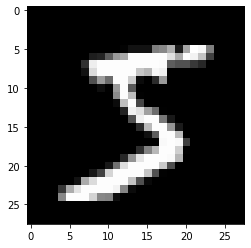

In [94]:
## Visulaizo
image, label = sample
plt.imshow(image.squeeze(), cmap='gray')
print('label:', label)

### Creating a Class for Custom Dataset Generation 

In [96]:
from torch.utils.data import Dataset
import random

# Dataset is there to be able to interact with DataLoader

class ImageNumDataset(Dataset):
  def __init__(self,tr_data):

    self.img_data = tr_data.data.reshape(-1,1,28,28).divide(255) # Normalizing Incoming input Images 
    self.y_images = tr_data.targets # Labels for the Images
    self.input_labels = [x for x in range(10)] # Creating numbers which are unique and between 0-9
    self.input_num = [random.choice(self.input_labels) for i in range(len(self.y_images))] # Create X_2 Data by randomly chosing a number between 0-9 for the len data loaded 
    self.one_hot_input = torch.nn.functional.one_hot(torch.as_tensor(self.input_num)) # One Hot Encoding the X_2 Feature
    self.y_multiples = torch.stack((self.y_images,torch.as_tensor(self.input_num)),dim=1).sum(dim=1) # Creating Y_2 which is a multiple of Y_1[i] and X_2[i]
    self.data = [(a,b,c,d) for a,b,c,d in zip(self.img_data,self.y_images,self.one_hot_input,self.y_multiples)]
    
    for i in range(len(self.y_images)):
      self.input_num.append(random.choice(self.input_labels))


  def __getitem__(self, index):
    return self.data[index]

  def __len__(self):
    return len(self.data)



In [97]:
all_data = ImageNumDataset(training_data)
sample = next(iter(all_data))

len(sample)

4

In [98]:
a,b,c,d=sample
a.shape,b,c.shape,d

(torch.Size([1, 28, 28]), tensor(5), torch.Size([10]), tensor(13))

### Creating Training Data in Batches

In [100]:
#DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
  #         batch_sampler=None, num_workers=0, collate_fn=None,
   #        pin_memory=False, drop_last=False, timeout=0,
    #       worker_init_fn=None, *, prefetch_factor=2,
     #      persistent_workers=False)
## Splitting the  data into a batches since we will be do a batch training
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(all_data, batch_size=10,
                                           shuffle=True, **kwargs)

print(f'The Number of Batches in the  Data is {len(train_loader)}')

The Number of Batches in the  Data is 6000


In [101]:
train_batch = next(iter(train_loader))
tr_images, tr_labels,tr_num,tr_num_multiples = train_batch
tr_images.shape, tr_num.shape

(torch.Size([10, 1, 28, 28]), torch.Size([10, 10]))

### Visualizing Image in a batch 

labels: tensor([2, 1, 1, 6, 1, 9, 8, 3, 6, 0])


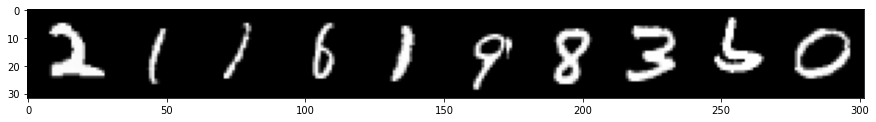

In [102]:
grid = torchvision.utils.make_grid(tr_images, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
print('labels:', tr_labels)

## 1.3 Neural Network for Handling Images from MNSIT Data 

In [103]:
import torch.nn as nn
import torch.nn.functional as F

In [41]:
## torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
#       dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

## torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)

## torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)

In [104]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    # 28 >26> 6x24x24 > 6x12x12 
    self.conv1 = nn.Conv2d(in_channels= 1 , out_channels=6 , kernel_size= 5 )# Given Image is a greyscale image with 1 channel , no of kernel is 6 and its size is 3 X 3
    #12>10>8> 12x8x8  > 12x4x4 
    self.conv2 = nn.Conv2d(in_channels=6,out_channels=12, kernel_size=5)
    
    self.fc_1 = nn.Linear(in_features= 12*4*4+10, out_features=120)
    self.fc_2 = nn.Linear(in_features= 120, out_features=60)
    self.out_1 = nn.Linear(in_features= 60, out_features=10)
    self.out_2 = nn.Linear(in_features= 60, out_features=19)

  def forward(self, im_t,num_t):
    # input layer
    x = im_t

    # conv1 layer
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2) # 28 | 24 | 12

    # conv2 layer
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2) # 12 | 8 | 4 >> 12x4x4

    # reshape
    x = x.reshape(-1, 12 * 4 * 4)
    x = torch.cat((x,num_t),dim=1) # Combining flattened convoutional Extracted Features with the one hot encoded for the randomly generated number 

    #print(x.shape)
    # fc1 layer
    x = self.fc_1(x)
    x = F.relu(x)

    # fc2 layer
    x = self.fc_2(x)
    x = F.relu(x)

    # output layer
    x_1 = self.out_1(x) # Ouput for image data 
    x_2 = self.out_2(x) # Output for the multplication of the label with label randomly generated number 
    # x = F.softmax(x, dim=1)
    return x_1, x_2

    

### GPU Training 

In [106]:
network = Network().to(device)
print(network)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=202, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=60, bias=True)
  (out_1): Linear(in_features=60, out_features=10, bias=True)
  (out_2): Linear(in_features=60, out_features=19, bias=True)
)


In [107]:
for name , params in network.named_parameters():
  print(name,'\t\t',params.shape)

conv1.weight 		 torch.Size([6, 1, 5, 5])
conv1.bias 		 torch.Size([6])
conv2.weight 		 torch.Size([12, 6, 5, 5])
conv2.bias 		 torch.Size([12])
fc_1.weight 		 torch.Size([120, 202])
fc_1.bias 		 torch.Size([120])
fc_2.weight 		 torch.Size([60, 120])
fc_2.bias 		 torch.Size([60])
out_1.weight 		 torch.Size([10, 60])
out_1.bias 		 torch.Size([10])
out_2.weight 		 torch.Size([19, 60])
out_2.bias 		 torch.Size([19])


In [109]:
## Evaluating Function 
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [110]:
import torch.optim as optim
optimizer = optim.Adam(network.parameters(), lr=0.01) 

for epoch in range(10):

    total_loss = 0
    t_loss_1 = 0 
    t_loss_2 = 0
    total_correct_1 = 0
    total_correct_2 = 0

    for batch in train_loader: # Get Batch
        images, labels, num_input, num_mults = batch 
        num_input, num_mults = num_input.to(device), num_mults.to(device) # Loading data to the GPU
        images, labels = images.to(device), labels.to(device) # Loading data to the GPU


        preds_1,preds_2 = network(images,num_input) # Pass Batches of data to obtain prediction 
        loss_1 = F.cross_entropy(preds_1, labels) # Calculate Loss_1
        loss_2 = F.cross_entropy(preds_2, num_mults) # Calculate Loss_2
        total_loss_1_2 = loss_1 + loss_2 # Total Loss

        optimizer.zero_grad() # Set gradinent to zero for every backpropagation 
        total_loss_1_2.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        t_loss_1 += loss_1.item() # Loss for the image Data 
        t_loss_2 += loss_2.item() # Loss for the mulplication output 

        total_loss += total_loss_1_2.item()
        total_correct_1 += get_num_correct(preds_1, labels)
        total_correct_2 += get_num_correct(preds_2, num_mults)

    print(
        "epoch", epoch, 
        "total_correct_mnsit:", total_correct_1, 
        "total_correct_mul:", total_correct_2, 
        "image_loss:", t_loss_1,
        "mul_loss:", t_loss_2,
        "loss:", total_loss
    )

epoch 0 total_correct_mnsit: 53797 total_correct_mul: 47339 image_loss: 2185.8504115049727 mul_loss: 4139.001356271736 loss: 6324.851769627188
epoch 1 total_correct_mnsit: 55350 total_correct_mul: 54215 image_loss: 1767.8374100955953 mul_loss: 2273.5602654250397 loss: 4041.397670752718
epoch 2 total_correct_mnsit: 55542 total_correct_mul: 54515 image_loss: 1756.7808225607914 mul_loss: 2247.3188638893607 loss: 4004.0996855513076
epoch 3 total_correct_mnsit: 55419 total_correct_mul: 54563 image_loss: 1744.9126572008536 mul_loss: 2220.3282453607244 loss: 3965.2409016861347
epoch 4 total_correct_mnsit: 55520 total_correct_mul: 54723 image_loss: 1738.0924868581424 mul_loss: 2169.6213690340664 loss: 3907.7138566146605
epoch 5 total_correct_mnsit: 55734 total_correct_mul: 54924 image_loss: 1685.4733474981213 mul_loss: 2104.6122934794257 loss: 3790.0856454770983
epoch 6 total_correct_mnsit: 55584 total_correct_mul: 54792 image_loss: 1736.5988669241356 mul_loss: 2207.875217393551 loss: 3944.474